In [2]:
# Packages
import numpy as np
import random
import matplotlib.pyplot as plt

# Self-defined functions
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from util import util

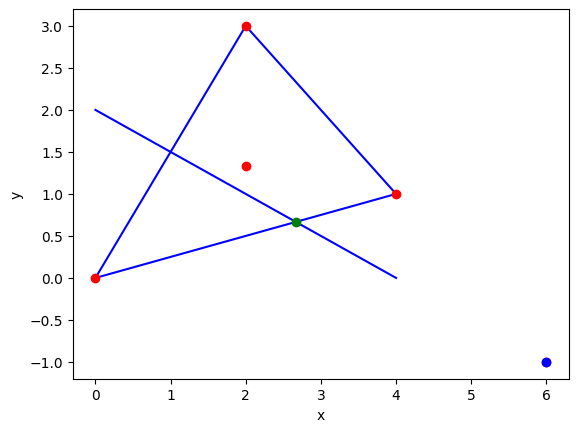

In [148]:
# Example
A = np.array([2,3])
B = np.array([4,1])
C = np.array([0,0])
G = (A + B + C) / 3
# R = np.array([0,1])
p0 = np.array([0,0])

# A = np.array([4,2])
# B = np.array([1,9])
# C = np.array([10,1])
    
util.v_triangle_2D(A,B,C)
util.v_line_2D(np.array([4,0]), np.array([0,2]))
plt.plot(A[0], A[1], 'o', color='r')
plt.plot(B[0], B[1], 'o', color='r')
plt.plot(C[0], C[1], 'o', color='r')
plt.plot(P[0], P[1], 'o', color='r')
plt.plot(Q[0], Q[1], 'o', color='g')
plt.plot(R[0], R[1], 'o', color='b')
# plt.plot(R[0], R[1], 'o', color='r')
G = util.v_triangle_barycentre(A,B,C)

In [349]:
class line_2D:
    def __init__(self, p1, p2, coef=[]):
        if len(coef)==3:
            self.coef = coef
        else:
            self.coef = self.line_formula(p1, p2)
        A, B, C = self.coef
        self.slope = - A / B
        self.C = C
    
    @staticmethod
    def line_formula(p1, p2):
        return np.array([p1[1]-p2[1], p2[0]-p1[0], p1[0]*p2[1] - p2[0]*p1[1]])
    
    def interpolate(self, p):
        x, y = p
        A, B, C = self.coef
        return A*x + B*y + C
    
    def is_parallel(self, line_coef):
        line_slope = - line_coef[0] / line_coef[1] 
        return line_slope == self.slope
    
    def get_two_points(self):
        A, B, C = self.coef
        p1 = np.array([-C/A, 0])
        p2 = np.array([0, -C/B])
        return p1, p2

In [727]:
class problem_2D:
    def __init__(self, vertices, slope=[1,2], ratio=0.5, learning_rate=0.05, num_iteration=1000):
        if not len(vertices) == 3:
            A = np.array([6,9])
            B = np.array([10,14])
            C = np.array([8,28])
            self.vertices = np.array([A, B, C])
        else:
            self.vertices = vertices
            
        A, B, C = self.vertices
        self.G = (vertices[0] + vertices[1] + vertices[2]) / 3
        # Edges
        self.line_AB = line_2D(A, B)
        self.line_BC = line_2D(B, C)
        self.line_CA = line_2D(C, A)
        
        # Initialize variable "C"
#         c= -(slope[0]*G[0]+slope[1]*G[1])
        c = -5
    
        # Decision boundary
        self.line = line_2D([0,0], [0,0], slope + [c])
        
        # Area realted
        self.ratio = ratio
        self.area = util.triangle_area(A, B, C)
        
        # Learning realted
        self.lr = learning_rate
        self.num_iteration = num_iteration
        
        
    def compute_PQR(self):
        A, B, C = self.line.coef
        if not(self.line_AB.is_parallel(self.line.coef)):
            A_, B_, C_ = self.line_AB.coef
            M = np.array([[A, B],[A_, B_]])
            self.dP_C = np.linalg.inv(M) @ np.array([[-1, 0], [0, -C_]])
            self.P=self.dP_C @ np.array([C, 1])
            
        if not(self.line_BC.is_parallel(self.line.coef)):
            A_, B_, C_ = self.line_BC.coef
            M = np.array([[A, B],[A_, B_]])
            self.dQ_C = np.linalg.inv(M) @ np.array([[-1, 0], [0, -C_]])
            self.Q=self.dQ_C @ np.array([C, 1])
            
        if not(self.line_CA.is_parallel(self.line.coef)):
            A_, B_, C_ = self.line_CA.coef
            M = np.array([[A, B],[A_, B_]])
            self.dR_C = np.linalg.inv(M) @ np.array([[-1, 0], [0, -C_]])
            self.R = self.dR_C @ np.array([C, 1])
        
            
#     Use variable "C" to compute the area of enclosing part and the gradient dS/dC, denoted by dS_C
    def compute_area_and_gradient(self):
        A, B, C = self.vertices
        S = 0
        dS_C = 0
        if(self.line.interpolate(A) > 0):
            AR = self.R - A
            AP = self.P - A
            dAR_C = self.dR_C.copy()
            dAR_C[:,1] -= A
            dAP_C = self.dP_C.copy()
            dAP_C[:,1] -= A
            S += np.cross(AR, AP) / 2
            dS_C += self.cross_product_gradients(dAR_C, dAP_C) / 2
            
        if(self.line.interpolate(B) > 0):
            BP = self.P - B
            BQ = self.Q - B
            dBP_C = self.dP_C.copy()
            dBP_C[:,1] -= B
            dBQ_C = self.dQ_C.copy()
            dBQ_C[:,1] -= B
            S += np.cross(BP, BQ) / 2
            dS_C += self.cross_product_gradients(dBP_C, dBQ_C) / 2
            
        if(self.line.interpolate(C) > 0):   
            CQ = self.Q - C
            CR = self.R - C         
            dCQ_C = self.dQ_C.copy()
            dCQ_C[:,1] -= C
            dCR_C = self.dR_C.copy()
            dCR_C[:,1] -= C
            S += np.cross(CQ, CR) / 2
            dS_C += self.cross_product_gradients(dCQ_C, dCR_C) / 2
            
        return S, dS_C
    
    def loss_MSE(self):
        return np.power(self.S-self.ratio*self.area, 2)
    
#     def forward_propagation(self):
        
    def backward_propagation(self):
#         dL/dS
        dL_S = 2*self.S-2*self.ratio*self.area
#         dL/dC
        self.dL_C=dL_S*self.dS_C
        
    def update_parameters(self):
        A, B, C = self.line.coef
        C -= self.lr * self.dL_C
        self.line = line_2D([0,0], [0,0], np.array([A, B, C]))

    def cross_product_gradients(self, M1, M2):
        A, B, C = self.line.coef
        dS_C = problem_2D.cross_product_helper(M1[0], M2[1]) - problem_2D.cross_product_helper(M1[1], M2[0])
        return 2*dS_C[0]*C + 2*dS_C[1]
        
    @staticmethod
    def cross_product_helper(v1, v2):
        a, b = v1
        c, d = v2
        return np.array([a*c, a*d + b*c, b*d])
    
    def visualize(self):
        A, B, C = self.vertices
        util.v_triangle_2D(A,B,C)
        p1, p2 = self.line.get_two_points()
        util.v_line_2D(p1, p2)
        plt.plot(A[0], A[1], 'o', color='c', label='A')
        plt.plot(B[0], B[1], 'o', color='m', label='B')
        plt.plot(C[0], C[1], 'o', color='y', label='C')
        plt.plot(self.P[0], self.P[1], 'o', color='r', label='P')
        plt.plot(self.Q[0], self.Q[1], 'o', color='g', label='Q')
        plt.plot(self.R[0], self.R[1], 'o', color='b', label='R')
        plt.legend()
        plt.show()
    
    def train_one_round(self):
        self.compute_PQR()
        self.S, self.dS_C = self.compute_area_and_gradient()
        print("The loss is: ", self.loss_MSE())
        self.backward_propagation()
        self.update_parameters()
        
        print("The enclosing area is: ", self.S)
        print("一半面积： ", self.ratio*self.area)
        print("dL/dC is: ", self.dL_C)
        self.visualize()
        
    def train(self):
        for i in range(self.num_iteration):
            self.compute_PQR()
            self.S, self.dS_C = self.compute_area_and_gradient()
            self.backward_propagation()
            self.update_parameters()
        
        print("The loss is: ", self.loss_MSE())
        print("The enclosing area is: ", self.S)
        self.visualize()

In [724]:
test=problem_2D(np.array([A,B,C]))

The loss is:  6.25
The enclosing area is:  0
一半面积：  2.5
dL/dC is:  -0.0


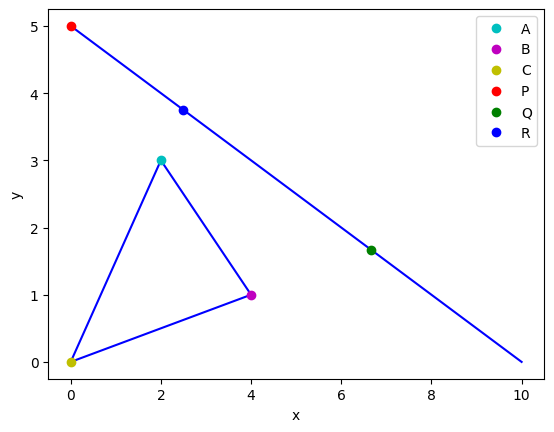

In [726]:
test.train_one_round()

The loss is:  1.597443333072549e-29
The enclosing area is:  2.500000000000004


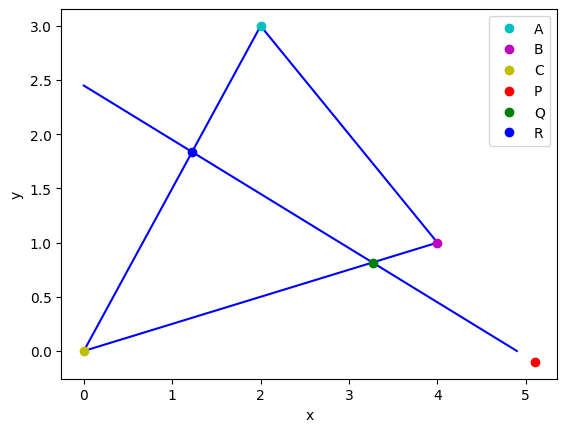

In [683]:
test.train()